# Training a CNN + FNO on the 1D SWE 

### Initialize

In [1]:
save_plots = 0
save_results = 0
n_epochs_CNN = 100
n_epochs_FNO = 100

### Load packages

In [2]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

import time
import h5py
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

plt.rc('axes', titlesize=16)  # Set default size for axes titles
plt.rc('axes', labelsize=16)  # Set default size for axis labels

cpu


C:\Users\Matteo\AppData\Local\Temp\ipykernel_22512\3286783365.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Functions

In [3]:
def prepare_data(h_all, p_train, p_val):
    # Fetch the dimensions of the input
    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, timesteps, train_x, train_y, val_x, val_y, test_x, test_y

# Prepare data in sequences
def prepare_data_sequences(train_x, train_y, seq_length):
    # Fetch the dimensions of the input data
    timesteps, spatial_steps = train_x.shape[0], train_x.shape[1]

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = train_x[i:i + seq_length]
        y_seq[i] = train_y[i + seq_length]
    return x_seq, y_seq


### Plot initial condition

Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (615, 200)
'u_all' loaded with shape: (615, 200)
'x' loaded with shape: (200,)
'time_all' loaded with shape: (615,)


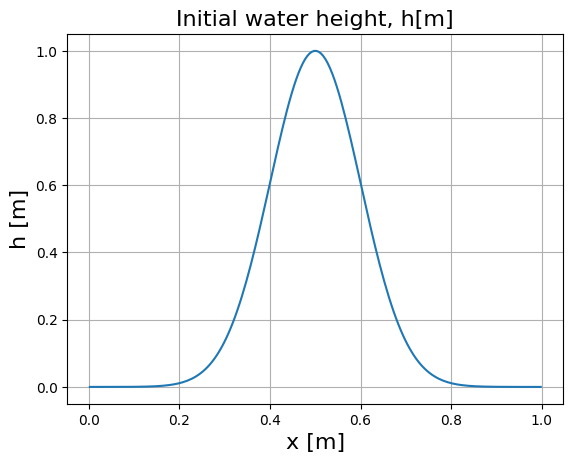

In [4]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_2.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")

# Plot the initial condition
plt.figure()
plt.plot(x.squeeze(), h_all[0,:])
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.title('Initial water height, h[m]')
plt.grid()

if save_plots:
    plt.savefig('plots/NN_initial_1D.pdf', format='pdf')
plt.show()

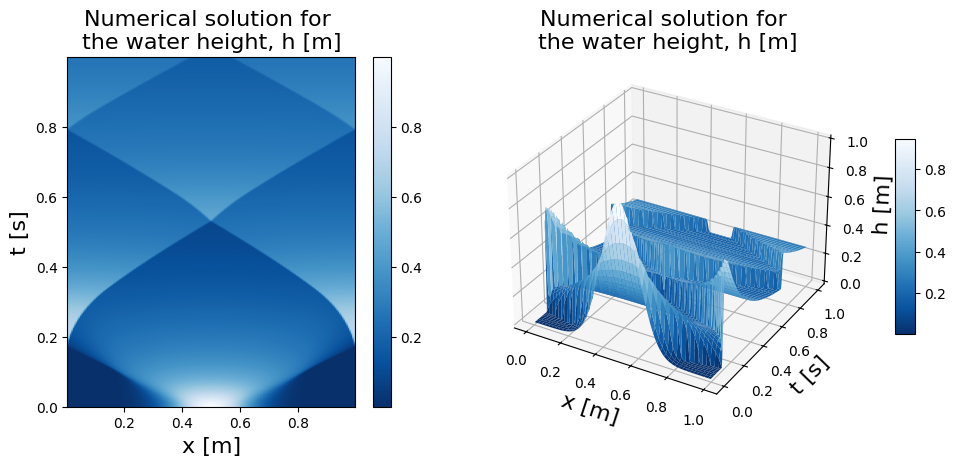

In [5]:
cmap = 'Blues_r'
X, T = np.meshgrid(x, time_all)

# Plot the data in x,t space
fig = plt.figure(figsize=(12, 5))

# Plot the initial condition
ax0 = fig.add_axes([0.05, 0.15, 0.3, 0.7])  # [left, bottom, width, height]
plt.imshow(h_all, aspect='auto', cmap=cmap, extent=[x[0], x[-1], time_all[-1], time_all[0]])
plt.colorbar(ax=ax0)
ax0.set_title('Numerical solution for \nthe water height, h [m]')
ax0.set_xlabel('x [m]')
ax0.set_ylabel('t [s]')
ax0.invert_yaxis()

# Plot in 3D
#ax1 = fig.add_subplot(122, projection='3d')
ax1 = fig.add_axes([0.4, 0.1, 0.4, 0.78], projection='3d')  # [left, bottom, width, height]
surf1 = ax1.plot_surface(X, T, h_all, cmap=cmap)
ax1.set_title('Numerical solution for \nthe water height, h [m]')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('t [s]')
ax1.set_zlabel('h [m]')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10, pad = 0.1)

if save_plots:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()

### Load exact solution

In [6]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_2_exact.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all_true = np.array(file['data_0']['h_all'][:-1])
    u_all_true = np.array(file['data_0']['u_all'][:-1])
    x_true = np.array(file['data_0']['x']).squeeze()
    time_all_true = np.array(file['data_0']['time_all']).squeeze()

    print(f"'h_all' loaded with shape: {h_all_true.shape}")
    print(f"'u_all' loaded with shape: {u_all_true.shape}")
    print(f"'x' loaded with shape: {x_true.shape}")
    print(f"'time_all' loaded with shape: {time_all_true.shape}")

Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (3111, 1000)
'u_all' loaded with shape: (3111, 1000)
'x' loaded with shape: (1000,)
'time_all' loaded with shape: (3111,)


## CNN

### Load data from h5 file

In [99]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_2.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (615, 200)
'u_all' loaded with shape: (615, 200)
'x' loaded with shape: (200,)
'time_all' loaded with shape: (615,)


### Define model

In [100]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size, num_filters = 64, kernel_size= 3):
        super(CNNFlowmap, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, num_filters, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=1)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=1)
        self.final_conv = nn.Conv1d(num_filters, 1, kernel_size, padding=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.final_conv(x)
        x = x.squeeze()
        x = F.relu(x)
        return x
    
input_size = 100
hidden_size = 64
output_size = 100
input_channels = 10 # seq_length

# Instantiate the model
model = CNNFlowmap(input_channels, hidden_size, output_size)
print(model)

CNNFlowmap(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (final_conv): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=64, out_features=100, bias=True)
)


### Prepare data

In [101]:
## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val

n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)
print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)

# Prepare data in sequences
seq_len = 10

train_x_seq, train_y_seq = prepare_data_sequences(train_x, train_y, seq_len)
print("Training sequences:", train_x_seq.shape, train_y_seq.shape)

val_x_seq, val_y_seq = prepare_data_sequences(val_x, val_y, seq_len)
test_x_seq, test_y_seq = prepare_data_sequences(test_x, test_y, seq_len)

batch_size = 32

# Create the data loaders
train_dataset = torch.utils.data.TensorDataset(train_x_seq, train_y_seq)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_x_seq, val_y_seq)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_train = 369, n_val = 123, n_test = 123
Training data: torch.Size([369, 200]) torch.Size([369, 200])
Validation data: torch.Size([123, 200]) torch.Size([123, 200])
Test data: torch.Size([122, 200]) torch.Size([122, 200])
Training sequences: torch.Size([359, 10, 200]) torch.Size([359, 200])


### Train model

In [81]:
# Define lists to store the losses
loss_train = []
loss_val = []

best_loss = float('inf')

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_CNN
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X_val, batch_Y_val in val_loader:
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_Y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

    # Save model if validation loss is lowest
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model, 'models/CNN_1D_Gauss.pth')
        #print(f'Model saved with validation loss: {epoch_val_loss:.6f}')

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f}s")

Epoch 0/500, Training loss: 0.025638, Validation loss: 0.003064
Epoch 10/500, Training loss: 0.000220, Validation loss: 0.000094
Epoch 20/500, Training loss: 0.000111, Validation loss: 0.000046
Epoch 30/500, Training loss: 0.000064, Validation loss: 0.000039
Epoch 40/500, Training loss: 0.000037, Validation loss: 0.000027
Epoch 50/500, Training loss: 0.000028, Validation loss: 0.000020
Epoch 60/500, Training loss: 0.000025, Validation loss: 0.000021
Epoch 70/500, Training loss: 0.000018, Validation loss: 0.000020
Epoch 80/500, Training loss: 0.000017, Validation loss: 0.000020
Epoch 90/500, Training loss: 0.000022, Validation loss: 0.000026
Epoch 100/500, Training loss: 0.000010, Validation loss: 0.000021
Epoch 110/500, Training loss: 0.000008, Validation loss: 0.000021
Epoch 120/500, Training loss: 0.000007, Validation loss: 0.000023
Epoch 130/500, Training loss: 0.000005, Validation loss: 0.000021
Epoch 140/500, Training loss: 0.000028, Validation loss: 0.000024
Epoch 150/500, Traini

In [82]:
# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_CNN_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_CNN}") 

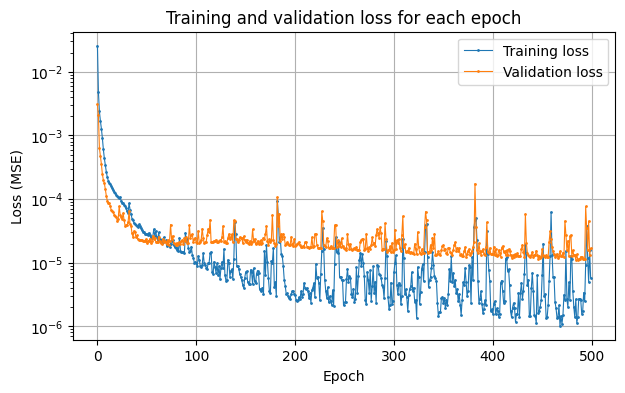

In [83]:
filename = 'plots/1D_CNN_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [102]:
# Load the best model
model = torch.load('models/CNN_1D_Gauss.pth')

# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x_seq).cpu().detach().numpy()
    pred_val = model(val_x_seq).cpu().detach().numpy()
    pred_test = model(test_x_seq).cpu().detach().numpy()

# Combine the sequences
pred_all = np.concatenate((pred_train, pred_val, pred_test), axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

(584, 200)
Train loss: 1.79e-06
Validation loss: 1.11e-05
Test loss: 5.16e-06


C:\Users\Matteo\AppData\Local\Temp\ipykernel_17136\497626391.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/CNN_1D_Gauss.pth')


In [103]:
X_all, Y_all = prepare_data_sequences(torch.tensor(a, dtype=torch.float32), torch.tensor(u, dtype=torch.float32), seq_len)

# Make predictions
model.eval()
with torch.no_grad():
    pred_all = model(X_all).cpu().detach().numpy()
    overall_loss = loss_fn(torch.tensor(pred_all), Y_all).item()
    print(f"Overall loss: {overall_loss:.2e}")

Overall loss: 4.52e-06


In [104]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_new(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_new(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 1.03e-03
Validation loss: 9.28e-04
Test loss: 7.86e-04


### Plot predictions

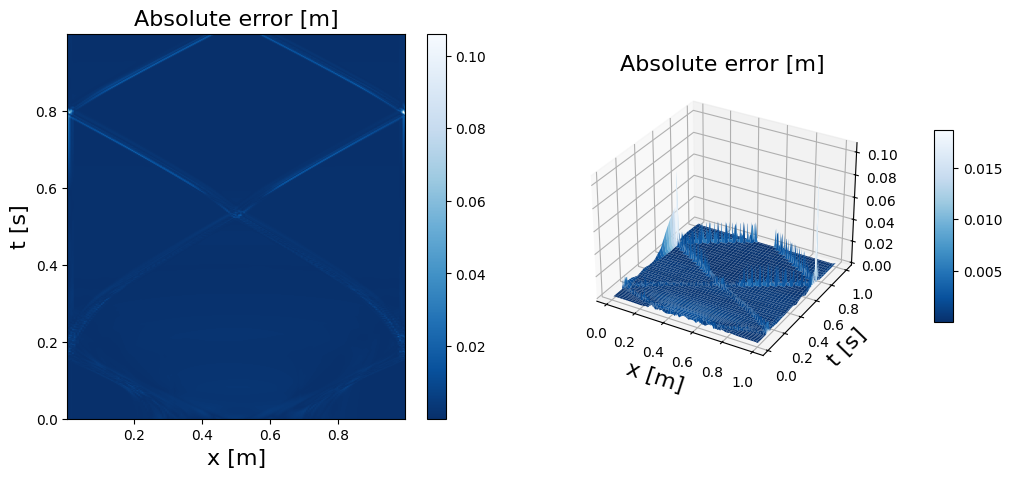

In [105]:
def plot_error(x, t_all, pred_all, u, save, filename):
    # Prepare grid
    X, T = np.meshgrid(x, t_all)
    cmap = 'Blues_r'

    fig = plt.figure(figsize=(12, 5))
    ax0 = fig.add_subplot(121)
    #ax0 = fig.add_axes([0.05, 0.15, 0.3, 0.7])  # [left, bottom, width, height]
    plt.imshow(np.abs(pred_all-u), aspect='auto', cmap=cmap, extent=[x[0], x[-1], time_all[-1], time_all[0]])
    plt.colorbar(ax=ax0)
    ax0.set_title('Absolute error [m]')
    ax0.set_xlabel('x [m]')
    ax0.set_ylabel('t [s]')
    ax0.invert_yaxis()

    ax1 = fig.add_subplot(122, projection='3d')
    #ax1 = fig.add_axes([0.4, 0.1, 0.4, 0.85], projection='3d')  # [left, bottom, width, height]
    surf = ax1.plot_surface(X, T, np.abs(pred_all-u), cmap=cmap)
    ax1.set_title('Absolute error [m]')
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('t [s]')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.15)  # Colorbar for 3D plot

    if save:
        plt.savefig(filename)

    plt.show()

plot_error(x, time_all[seq_len+1:], pred_all, u[seq_len:], save_plots, 'plots/1D_CNN_error.pdf')

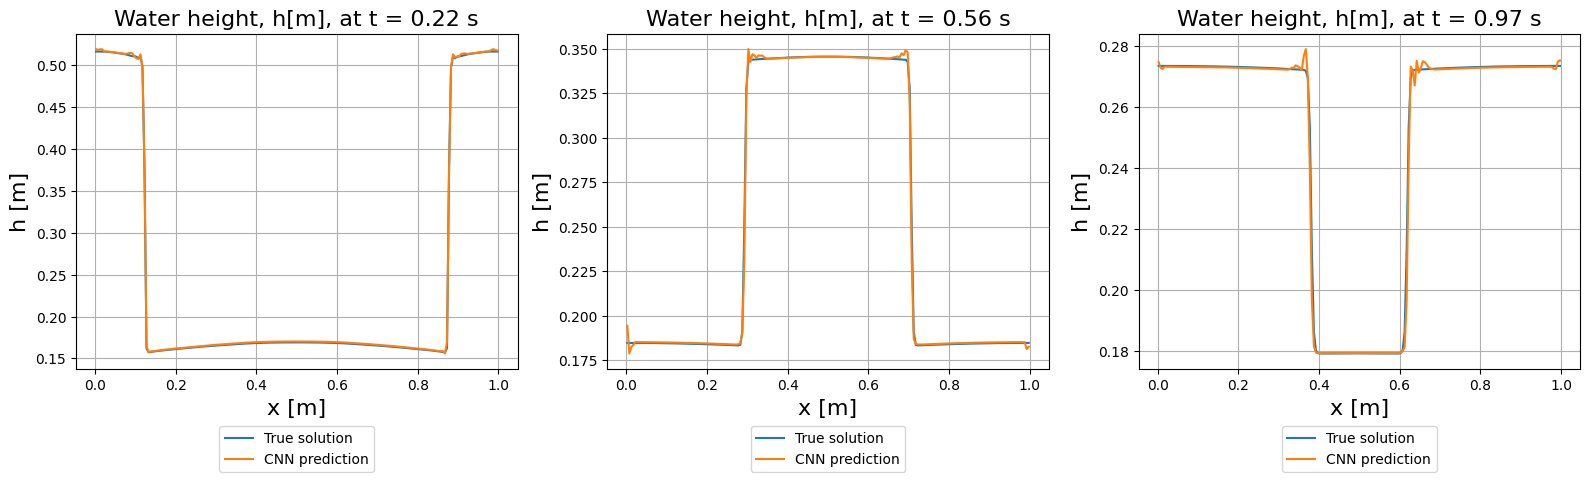

In [107]:
# Plot for some given time steps
indices = [200, 400, 600]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, u[idx], label='True solution')
    ax.plot(x, pred_all[idx-seq_len], label='CNN prediction')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('h [m]')
    ax.set_title(f'Water height, h[m], at t = {time_all[idx]:.2f} s')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
    ax.grid()

plt.tight_layout()

if save_plots:
    plt.savefig('plots/1D_CNN_pred_timesteps.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Make predictions new initial condition

In [108]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_1.h5', 'r') as file:
    for key in file.keys():
        #print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            #print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                #print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.real(np.array(file['data_0']['h_all'][:-1]))
    u_all = np.real(np.array(file['data_0']['u_all'][:-1]))
    x = np.real(np.array(file['data_0']['x']).squeeze())
    time_all = np.real(np.array(file['data_0']['time_all']).squeeze())
    sigma = np.array(file['data_0']['sigma'])
    mu = np.array(file['data_0']['mu'])

print(f"'h_all' loaded with shape: {h_all.shape}")
print(f"'u_all' loaded with shape: {u_all.shape}")
print(f"'x' loaded with shape: {x.shape}")
print(f"'time_all' loaded with shape: {time_all.shape}")

print('mu = ', mu)

'h_all' loaded with shape: (730, 200)
'u_all' loaded with shape: (730, 200)
'x' loaded with shape: (200,)
'time_all' loaded with shape: (730,)
mu =  [[0.3]]


In [109]:
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

train_x_seq, train_y_seq = prepare_data_sequences(train_x, train_y, seq_len)
val_x_seq, val_y_seq = prepare_data_sequences(val_x, val_y, seq_len)
test_x_seq, test_y_seq = prepare_data_sequences(test_x, test_y, seq_len)
print("Training sequences:", train_x_seq.shape, train_y_seq.shape)

# Time prediction
start_time = time.time()

# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x_seq).cpu().detach().numpy()
    pred_val = model(val_x_seq).cpu().detach().numpy()
    pred_test = model(test_x_seq).cpu().detach().numpy()

# Combine the sequences
pred_all = np.concatenate((pred_train, pred_val, pred_test), axis=0)

# End timer
end_time = time.time()
prediction_time = end_time - start_time

# Save the prediction time
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_time_new_ic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{prediction_time:.2f}") # Save with 2 decimals

print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MSE_test_new_ic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

n_train = 438, n_val = 146, n_test = 146
Training sequences: torch.Size([428, 10, 200]) torch.Size([428, 200])
(699, 200)
Train loss: 1.57e-05
Validation loss: 2.12e-05
Test loss: 2.60e-05


In [110]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_new(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_new(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MAE_test_new_ic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 1.21e-03
Validation loss: 1.50e-03
Test loss: 1.29e-03


# FNO

### Load data from h5 file

In [7]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_2.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (615, 200)
'u_all' loaded with shape: (615, 200)
'x' loaded with shape: (200,)
'time_all' loaded with shape: (615,)


### Define model

In [8]:
# Define FNO-based model
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=32,  # 64
    hidden_channels=32, 
    projection_channels=32, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu,
    dropout=0.1)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')

batch_size = 32 # 32


The model has 79969 parameters.


### Prepare data

In [9]:
def prepare_data_FNO(h_all, p_train, p_val):
    # Fetch the dimensions of the input
    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :] # Add channel dimension

    # Target u (shifted by one time step)
    u = h_all[1:]
    u = u[:, np.newaxis, :] # Add channel dimension

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, timesteps, train_x, train_y, val_x, val_y, test_x, test_y

In [10]:
# Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val

n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_FNO(h_all, p_train, p_val)

# Create the data loaders
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


n_train = 369, n_val = 123, n_test = 123


### Train model

In [154]:
loss_train = []
loss_val = []

model.to(device)

best_loss = float('inf')

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X_val, batch_Y_val in val_loader:
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_Y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

    # Save model if validation loss is lowest
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model, 'FNO_1D_Gauss.pth')

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f}s")


Epoch 0/500, Training loss: 0.014913, Validation loss: 0.003221
Epoch 10/500, Training loss: 0.000782, Validation loss: 0.000175
Epoch 20/500, Training loss: 0.000221, Validation loss: 0.000055
Epoch 30/500, Training loss: 0.000153, Validation loss: 0.000084
Epoch 40/500, Training loss: 0.000092, Validation loss: 0.000039
Epoch 50/500, Training loss: 0.000082, Validation loss: 0.000035
Epoch 60/500, Training loss: 0.000080, Validation loss: 0.000037
Epoch 70/500, Training loss: 0.000075, Validation loss: 0.000034
Epoch 80/500, Training loss: 0.000077, Validation loss: 0.000039
Epoch 90/500, Training loss: 0.000080, Validation loss: 0.000037
Epoch 100/500, Training loss: 0.000077, Validation loss: 0.000040
Epoch 110/500, Training loss: 0.000076, Validation loss: 0.000043
Epoch 120/500, Training loss: 0.000074, Validation loss: 0.000034
Epoch 130/500, Training loss: 0.000080, Validation loss: 0.000034
Epoch 140/500, Training loss: 0.000077, Validation loss: 0.000038
Epoch 150/500, Traini

In [71]:
# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_FNO_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_FNO}") 

In [72]:
filename = 'plots/1D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

NameError: name 'loss_train' is not defined

### Make predictions

In [115]:
# Load the best model
model = torch.load('models/FNO_1D_Gauss.pth')

# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x).cpu().detach().numpy()
    pred_val = model(val_x).cpu().detach().numpy()
    pred_test = model(test_x).cpu().detach().numpy()

# Combine the sequences
pred_all = np.concatenate((pred_train, pred_val, pred_test), axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

C:\Users\Matteo\AppData\Local\Temp\ipykernel_17136\1500477900.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/FNO_1D_Gauss.pth')


(614, 1, 200)
Train loss: 7.89e-05
Validation loss: 3.34e-05
Test loss: 1.75e-05


In [116]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y).item()
val_loss = loss_new(torch.tensor(pred_val), val_y).item()
test_loss = loss_new(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 3.26e-03
Validation loss: 1.84e-03
Test loss: 1.35e-03


### Plot predctions

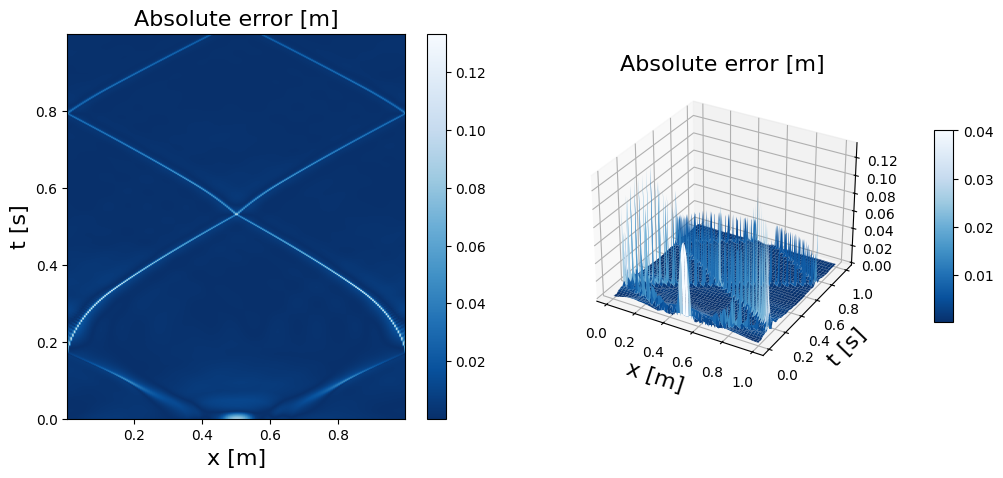

In [75]:
plot_error(x, time_all[1:], pred_all.squeeze(), u.squeeze(), save_plots, 'plots/1D_FNO_error.pdf')

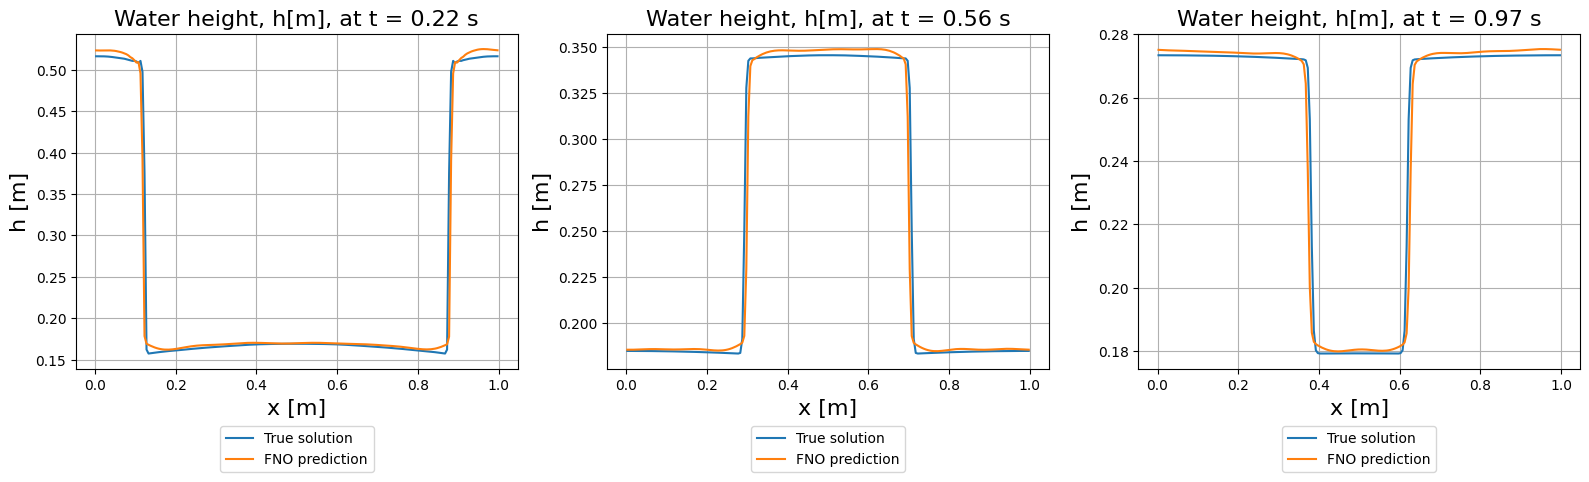

In [119]:
# Plot for some given time steps
indices = [200, 400, 600]

pred_all = pred_all.squeeze()
u = u.squeeze()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, u[idx], label='True solution')
    ax.plot(x, pred_all[idx-1], label='FNO prediction')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('h [m]')
    ax.set_title(f'Water height, h[m], at t = {time_all[idx]:.2f} s')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
    ax.grid()

plt.tight_layout()

if save_plots:
    plt.savefig('plots/1D_FNO_pred_timesteps.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Compare with exact solution

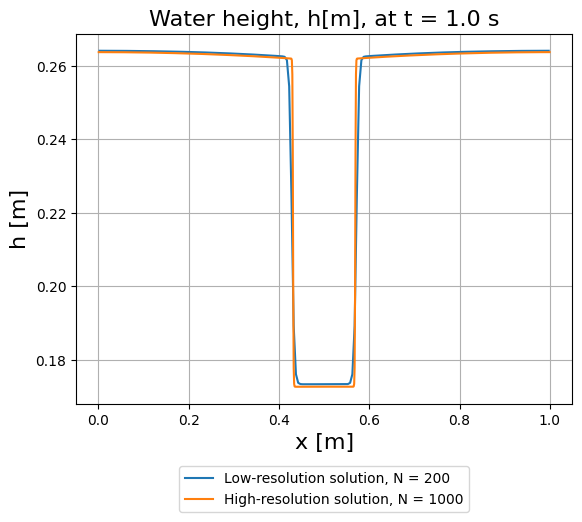

In [21]:
plt.figure()
plt.plot(x, h_all[-1], label='Low-resolution solution, N = 200')
plt.plot(x_true, h_all_true[-1], label='High-resolution solution, N = 1000')
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.15))
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.title('Water height, h[m], at t = 1.0 s')
plt.grid()

if 0:
    plt.savefig('plots/truncation_error.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Make predictions for new inital condition

In [121]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\1DGauss_mu_1.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.real(np.array(file['data_0']['h_all'][:-1]))
    u_all = np.real(np.array(file['data_0']['u_all'][:-1]))
    x = np.real(np.array(file['data_0']['x']).squeeze())
    time_all = np.real(np.array(file['data_0']['time_all']).squeeze())
    sigma = np.array(file['data_0']['sigma'])
    mu = np.array(file['data_0']['mu'])

print(f"'h_all' loaded with shape: {h_all.shape}")
print(f"'u_all' loaded with shape: {u_all.shape}")
print(f"'x' loaded with shape: {x.shape}")
print(f"'time_all' loaded with shape: {time_all.shape}")

print('mu = ', mu)

Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    mu
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (730, 200)
'u_all' loaded with shape: (730, 200)
'x' loaded with shape: (200,)
'time_all' loaded with shape: (730,)
mu =  [[0.3]]


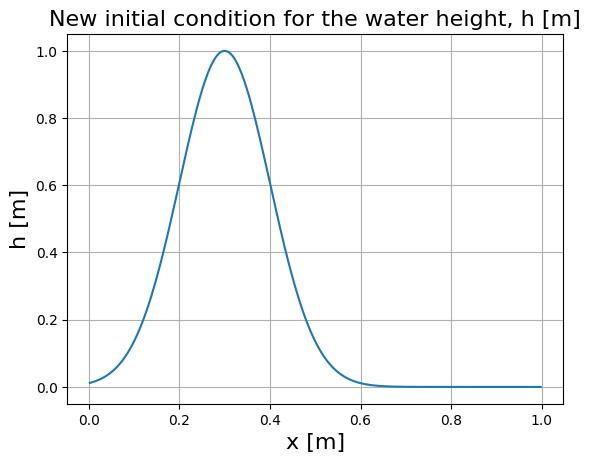

In [122]:
# Plot initial condition
plt.figure()
plt.plot(x, h_all[0, :])
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.title('New initial condition for the water height, h [m]')
plt.grid()

if 0:
    plt.savefig('plots/1D_new_ic.pdf', format='pdf')

plt.show()

In [123]:
# Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val

n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_FNO(h_all, p_train, p_val)

# Time prediction
start_time = time.time()

pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)

# End timer
end_time = time.time()
prediction_time = end_time - start_time

# Save the prediction time
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_time_newic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{prediction_time:.2f}") # Save with 2 decimals

pred_all.shape

n_train = 438, n_val = 146, n_test = 146


(729, 1, 200)

In [124]:
# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MSE_test_new_ic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y).item()
val_loss = loss_new(torch.tensor(pred_val), val_y).item()
test_loss = loss_new(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MAE_test_new_ic.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 7.29e-05
Validation loss: 2.59e-05
Test loss: 1.38e-05
Train loss: 3.39e-03
Validation loss: 2.24e-03
Test loss: 1.40e-03


### Plot prediction new inital condition

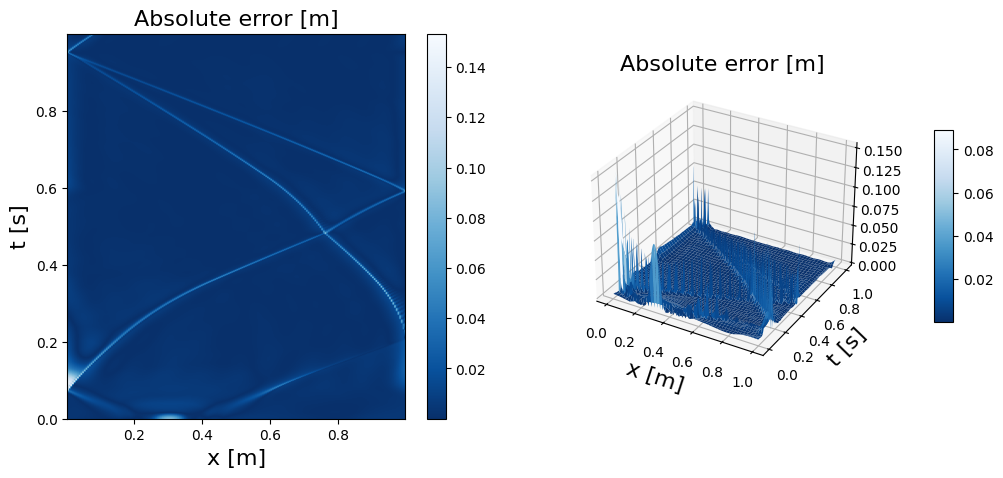

In [83]:
plot_error(x, time_all[1:], pred_all.squeeze(), u.squeeze(), save_plots, 'plots/1D_FNO_error_new_ic.pdf')

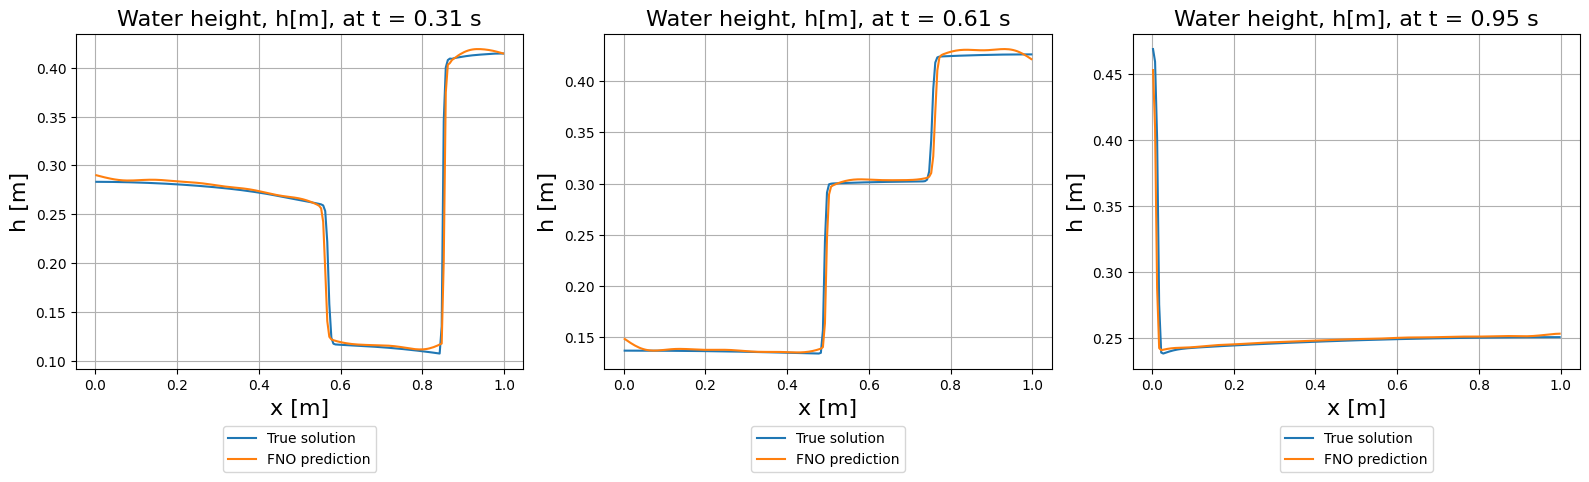

In [127]:
# Plot for some given time steps
indices = [300, 500, 700]

pred_all = pred_all.squeeze()
u = u.squeeze()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, u[idx], label='True solution')
    ax.plot(x, pred_all[idx-1], label='FNO prediction')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('h [m]')
    ax.set_title(f'Water height, h[m], at t = {time_all[idx]:.2f} s')
    ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.15))
    ax.grid()

plt.tight_layout()

if save_plots:
    plt.savefig('plots/1D_FNO_pred_timesteps.pdf_new_ic', format='pdf', bbox_inches='tight')

plt.show()